In [3]:
import sys
sys.path.append("./../task12")
sys.path.append("./../task11")

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import json
import time
from test_pid_controller import PIDTester

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
class ControllerBenchmark:
    def __init__(self):
        """Initialize benchmark environment and PID controller"""
        self.pid_tester = PIDTester(use_visualization=False)
        
        # Define workspace bounds
        self.x_bounds = (-0.1871, 0.253)
        self.y_bounds = (-0.1705, 0.2195)
        self.z_height = 0.1190  # Fixed Z height
        
        # Define test positions (ensuring they're within bounds)
        self.test_positions = [
            np.array([-0.08, 0.08, self.z_height]),    # Left
            np.array([-0.05, 0.15, self.z_height]),    # Top-left
            np.array([0.07, 0.17, self.z_height]),     # Top
            np.array([0.15, 0.15, self.z_height]),     # Top-right
            np.array([0.20, 0.08, self.z_height]),     # Right
            np.array([0.15, -0.08, self.z_height]),    # Bottom-right
            np.array([0.07, -0.10, self.z_height]),    # Bottom
            np.array([-0.05, -0.08, self.z_height])    # Bottom-left
        ]
        
        # Validate all test positions
        for pos in self.test_positions:
            if not self.is_valid_position(pos):
                raise ValueError(f"Invalid test position: {pos}")

    def is_valid_position(self, pos: np.ndarray) -> bool:
        """Check if position is valid (within bounds and finite)"""
        try:
            if not (np.isfinite(pos).all() and 
                   self.x_bounds[0] <= pos[0] <= self.x_bounds[1] and
                   self.y_bounds[0] <= pos[1] <= self.y_bounds[1]):
                return False
            return True
        except:
            return False

    def benchmark_pid(self) -> Dict[str, Any]:
        """Benchmark PID controller"""
        all_metrics = []
        trajectory_data = []
        
        for i, target_pos in enumerate(self.test_positions):
            print(f"\nTesting PID controller - Position {i+1}/{len(self.test_positions)}")
            print(f"Target position: {target_pos}")
            
            try:
                # Reset environment
                obs, _ = self.pid_tester.env.reset()
                initial_pos = np.array(self.pid_tester.env.sim.get_states()[f'robotId_{self.pid_tester.env.robot_id}']['pipette_position'])
                
                if not self.is_valid_position(initial_pos):
                    print(f"Invalid initial position: {initial_pos}, skipping test")
                    continue
                
                print(f"Initial position: {initial_pos}")
                
                start_time = time.time()
                
                # Create and run controller
                controller = self.pid_tester.create_controller(
                    self.pid_tester.default_gains['kp'],
                    self.pid_tester.default_gains['ki'],
                    self.pid_tester.default_gains['kd']
                )
                
                distances, times, velocities = self.pid_tester.run_test(controller, target_pos)
                
                if len(distances) > 0:
                    final_pos = np.array(self.pid_tester.env.sim.get_states()[f'robotId_{self.pid_tester.env.robot_id}']['pipette_position'])
                    
                    if not self.is_valid_position(final_pos):
                        print(f"Invalid final position: {final_pos}, skipping test")
                        continue
                        
                    print(f"Final position: {final_pos}")
                    
                    # Calculate metrics
                    metrics = self.pid_tester.calculate_performance_metrics(
                        distances, times, distances[0]
                    )
                    
                    # Add execution time metric
                    metrics['execution_time'] = float(time.time() - start_time)
                    
                    # Store data
                    trajectory_data.append({
                        'initial_pos': initial_pos.tolist(),
                        'target_pos': target_pos.tolist(),
                        'final_pos': final_pos.tolist(),
                        'distances': [float(d) for d in distances],
                        'times': [float(t) for t in times],
                        'velocities': [float(v) for v in velocities]
                    })
                    
                    metrics = {k: float(v) if isinstance(v, (np.float32, np.float64)) else v 
                              for k, v in metrics.items()}
                    
                    all_metrics.append(metrics)
                    
                    # Plot results
                    self.plot_test_results(distances, times, velocities, metrics)
                    
            except Exception as e:
                print(f"Error during test {i+1}: {str(e)}")
                continue
        
        if not all_metrics:
            raise ValueError("No successful tests completed")
            
        # Calculate average metrics
        avg_metrics = {
            key: float(np.mean([m[key] for m in all_metrics]))
            for key in all_metrics[0].keys()
        }
        
        return {
            'average_metrics': avg_metrics,
            'all_metrics': all_metrics,
            'trajectory_data': trajectory_data
        }

    def plot_test_results(self, distances: List[float], times: List[float], 
                         velocities: List[float], metrics: Dict[str, float]):
        """Plot results for a single test"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot distance vs time
        ax1.plot(times, distances, 'b-', label='Distance to Target')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Distance (m)')
        ax1.set_title('Distance to Target vs Time')
        ax1.grid(True)
        
        # Add metrics to plot
        metrics_text = (
            f"Settling Time: {metrics['settling_time']:.3f}s\n"
            f"Overshoot: {metrics['overshoot']:.1f}%\n"
            f"Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm\n"
            f"Rise Time: {metrics['rise_time']:.3f}s\n"
            f"Execution Time: {metrics['execution_time']:.3f}s"
        )
        ax1.text(0.02, 0.98, metrics_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot velocity vs time
        ax2.plot(times, velocities, 'r-', label='Velocity')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (m/s)')
        ax2.set_title('Velocity vs Time')
        ax2.grid(True)
        
        # Add PID gains to plot
        gains_text = (
            f"PID Gains:\n"
            f"kp: {self.pid_tester.default_gains['kp']}\n"
            f"ki: {self.pid_tester.default_gains['ki']}\n"
            f"kd: {self.pid_tester.default_gains['kd']}"
        )
        ax2.text(0.02, 0.98, gains_text,
                transform=ax2.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()

    def plot_summary(self, results: Dict):
        """Create summary plots for PID controller performance"""
        metrics = ['settling_time', 'overshoot', 'steady_state_error', 'rise_time', 'execution_time']
        
        fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))
        fig.suptitle('PID Controller Performance Summary', fontsize=16)
        
        all_metrics = results['all_metrics']
        positions = [f"Pos {i+1}" for i in range(len(all_metrics))]
        
        for i, metric in enumerate(metrics):
            values = [m[metric] for m in all_metrics]
            
            axes[i].bar(positions, values)
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].grid(True)
            
            # Add value labels on bars
            for j, v in enumerate(values):
                axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('pid_performance_summary.png')
        plt.show()


Testing PID controller - Position 1/8
Target position: [-0.08   0.08   0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 228 steps! Final distance: 0.51mm
Final position: [-0.0815  0.0801  0.119 ]


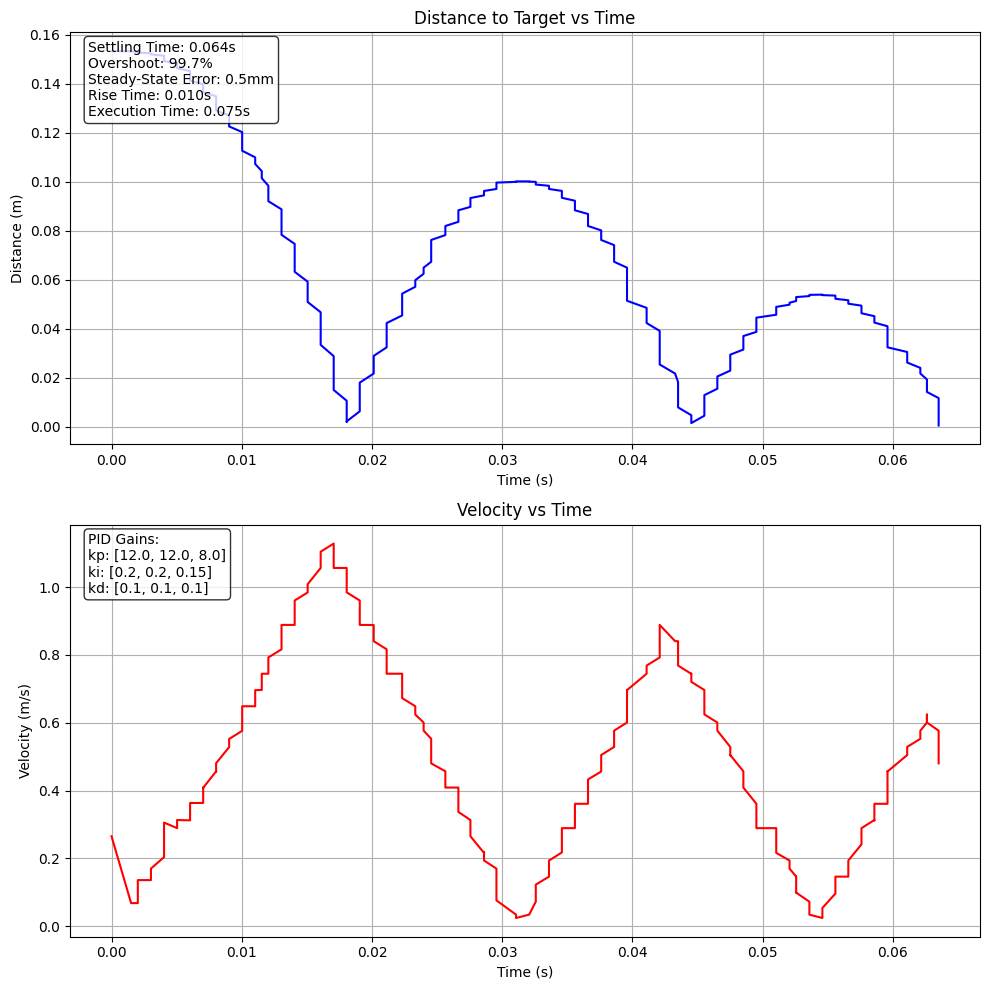


Testing PID controller - Position 2/8
Target position: [-0.05   0.15   0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 133 steps! Final distance: 0.60mm
Final position: [-0.0475  0.1499  0.119 ]


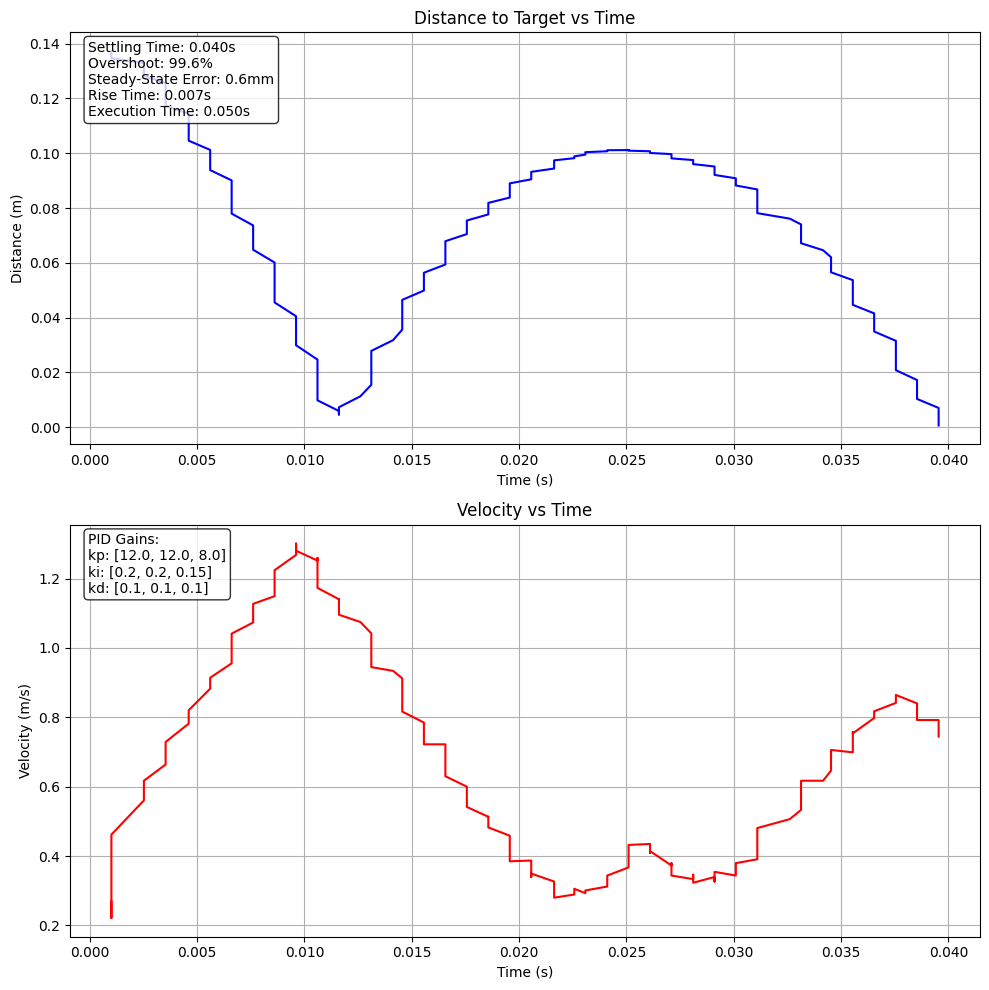


Testing PID controller - Position 3/8
Target position: [0.07  0.17  0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 146 steps! Final distance: 0.80mm
Final position: [0.0699 0.1698 0.119 ]


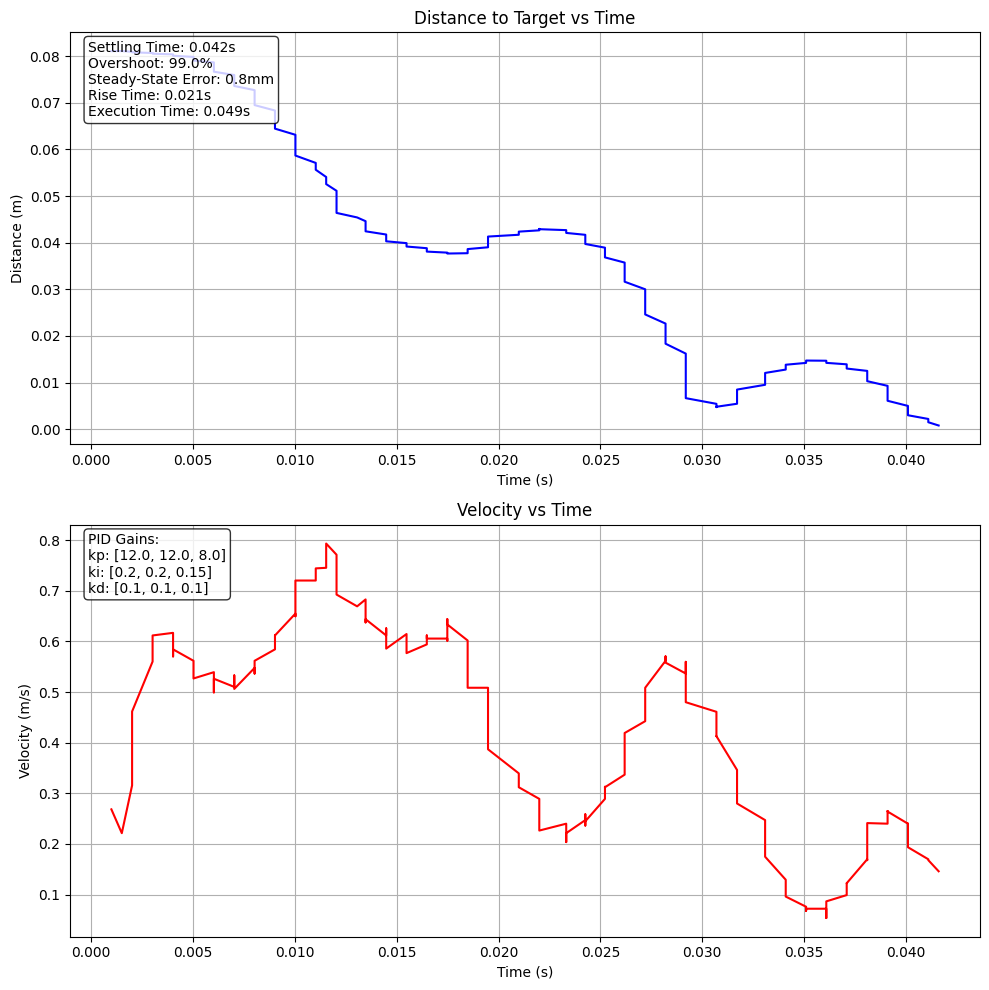


Testing PID controller - Position 4/8
Target position: [0.15  0.15  0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 145 steps! Final distance: 0.71mm
Final position: [0.1498 0.15   0.119 ]


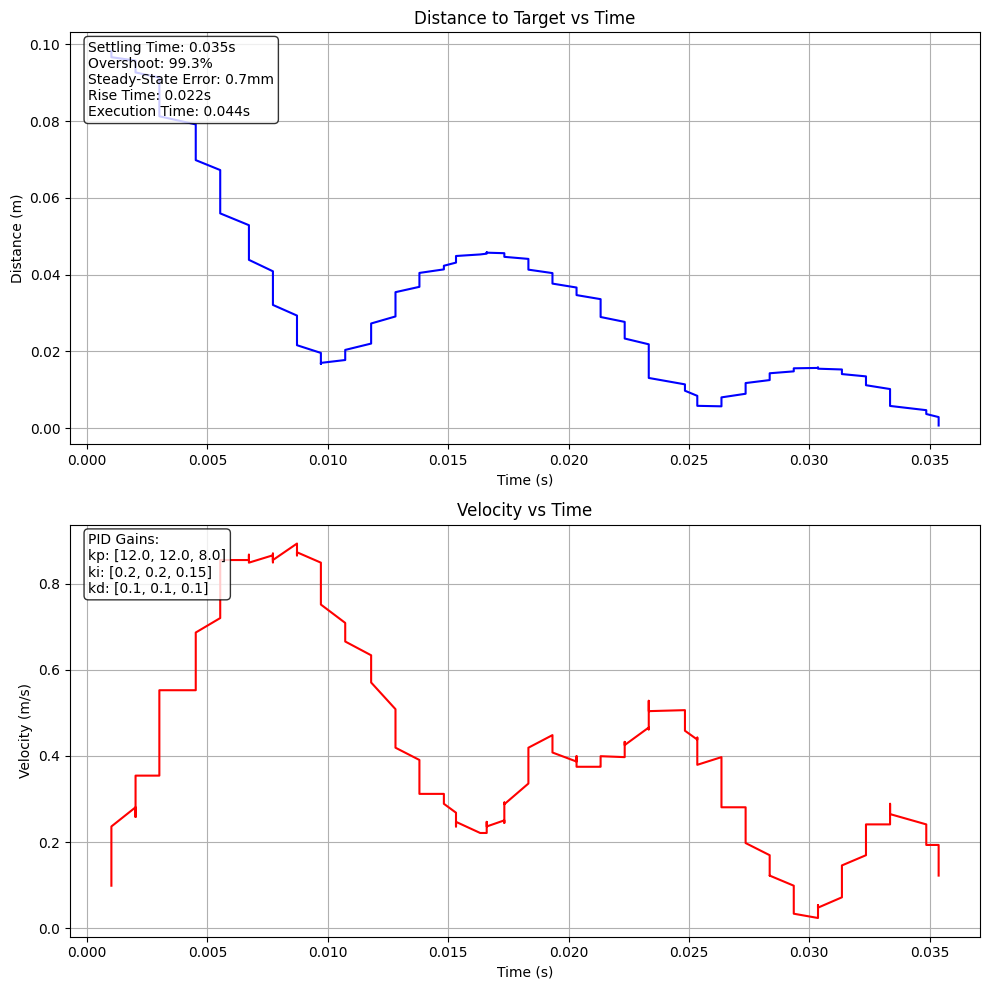


Testing PID controller - Position 5/8
Target position: [0.2   0.08  0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 128 steps! Final distance: 0.71mm
Final position: [0.1974 0.08   0.119 ]


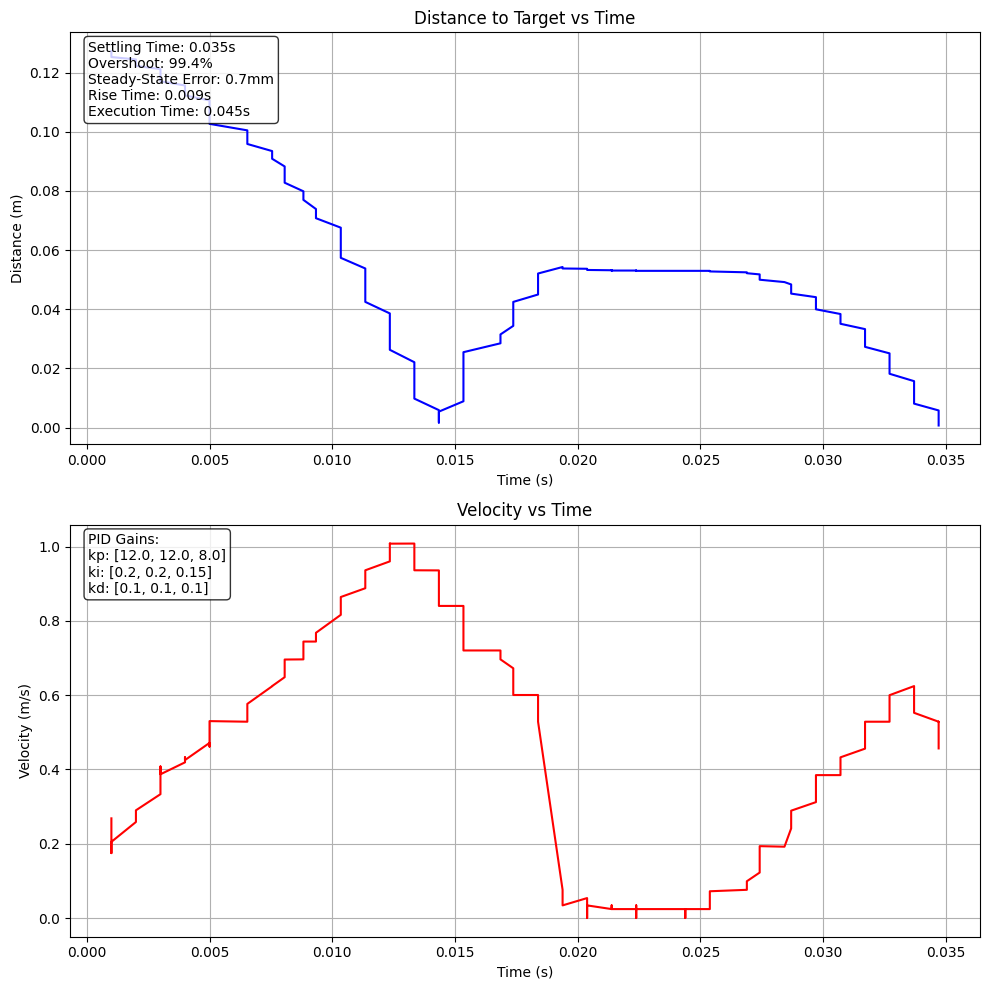


Testing PID controller - Position 6/8
Target position: [ 0.15  -0.08   0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 229 steps! Final distance: 0.67mm
Final position: [ 0.1503 -0.0813  0.119 ]


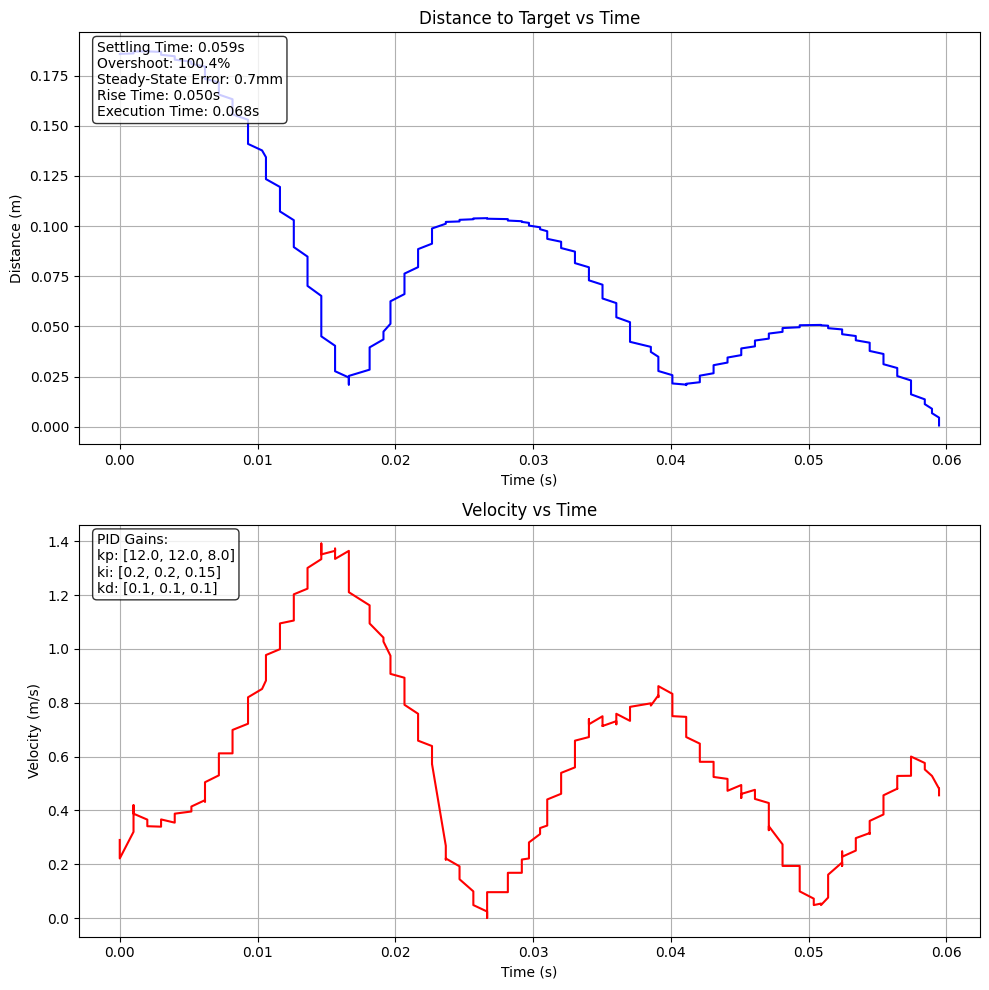


Testing PID controller - Position 7/8
Target position: [ 0.07  -0.1    0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 207 steps! Final distance: 0.20mm
Final position: [ 0.0701 -0.1015  0.119 ]


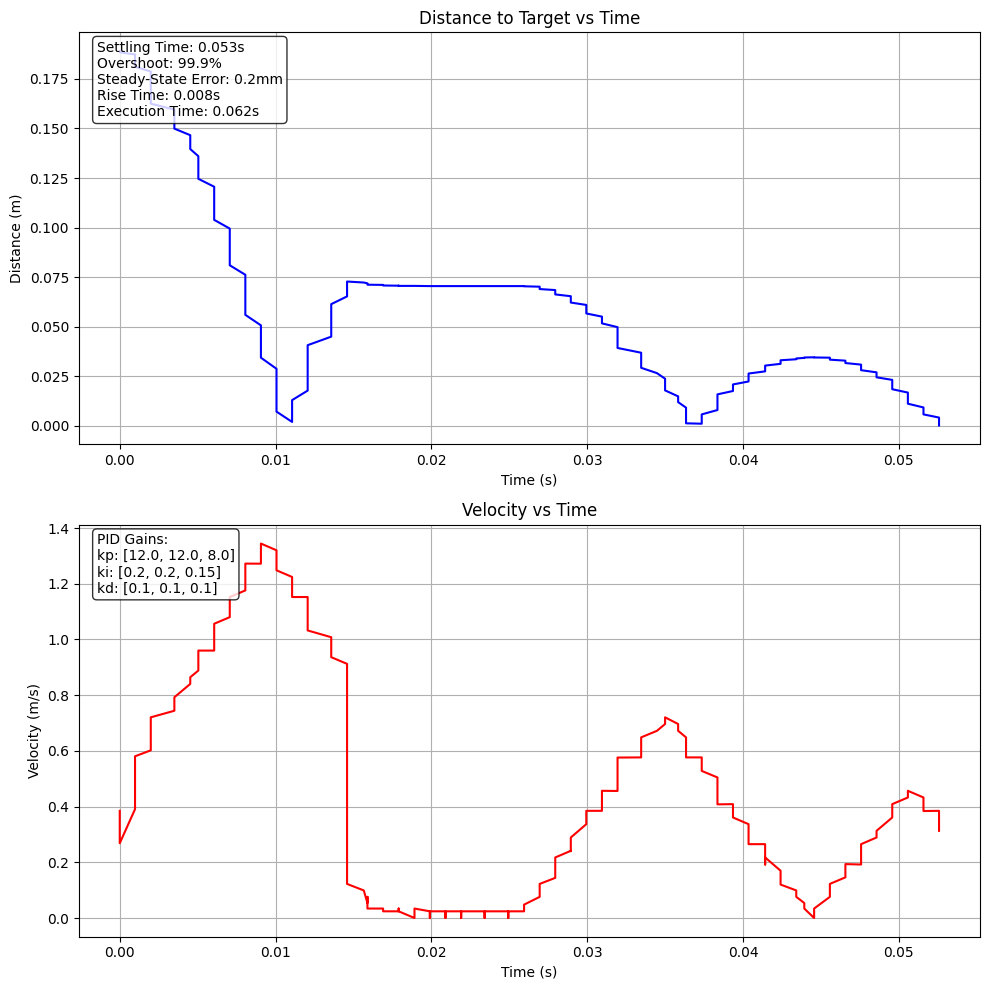


Testing PID controller - Position 8/8
Target position: [-0.05  -0.08   0.119]
Initial position: [0.073 0.089 0.119]
Goal reached in 264 steps! Final distance: 0.50mm
Final position: [-0.05   -0.0797  0.119 ]


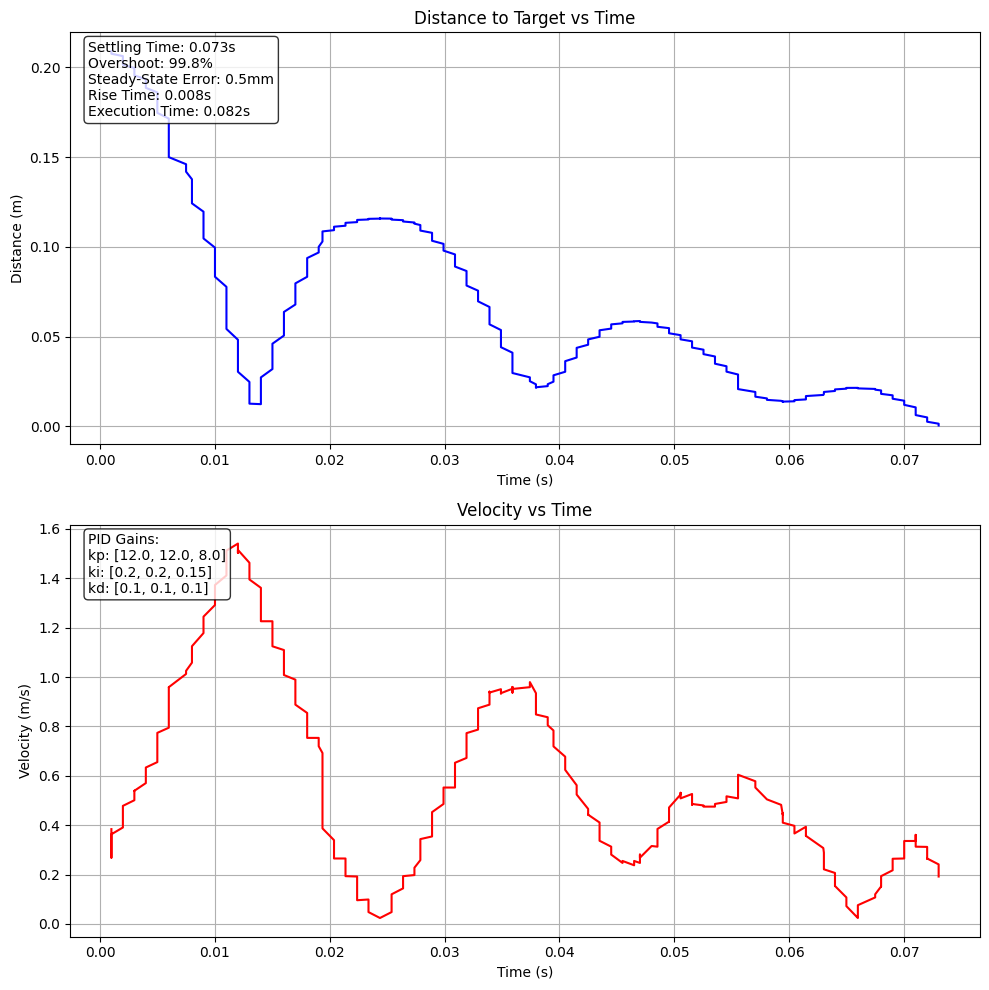

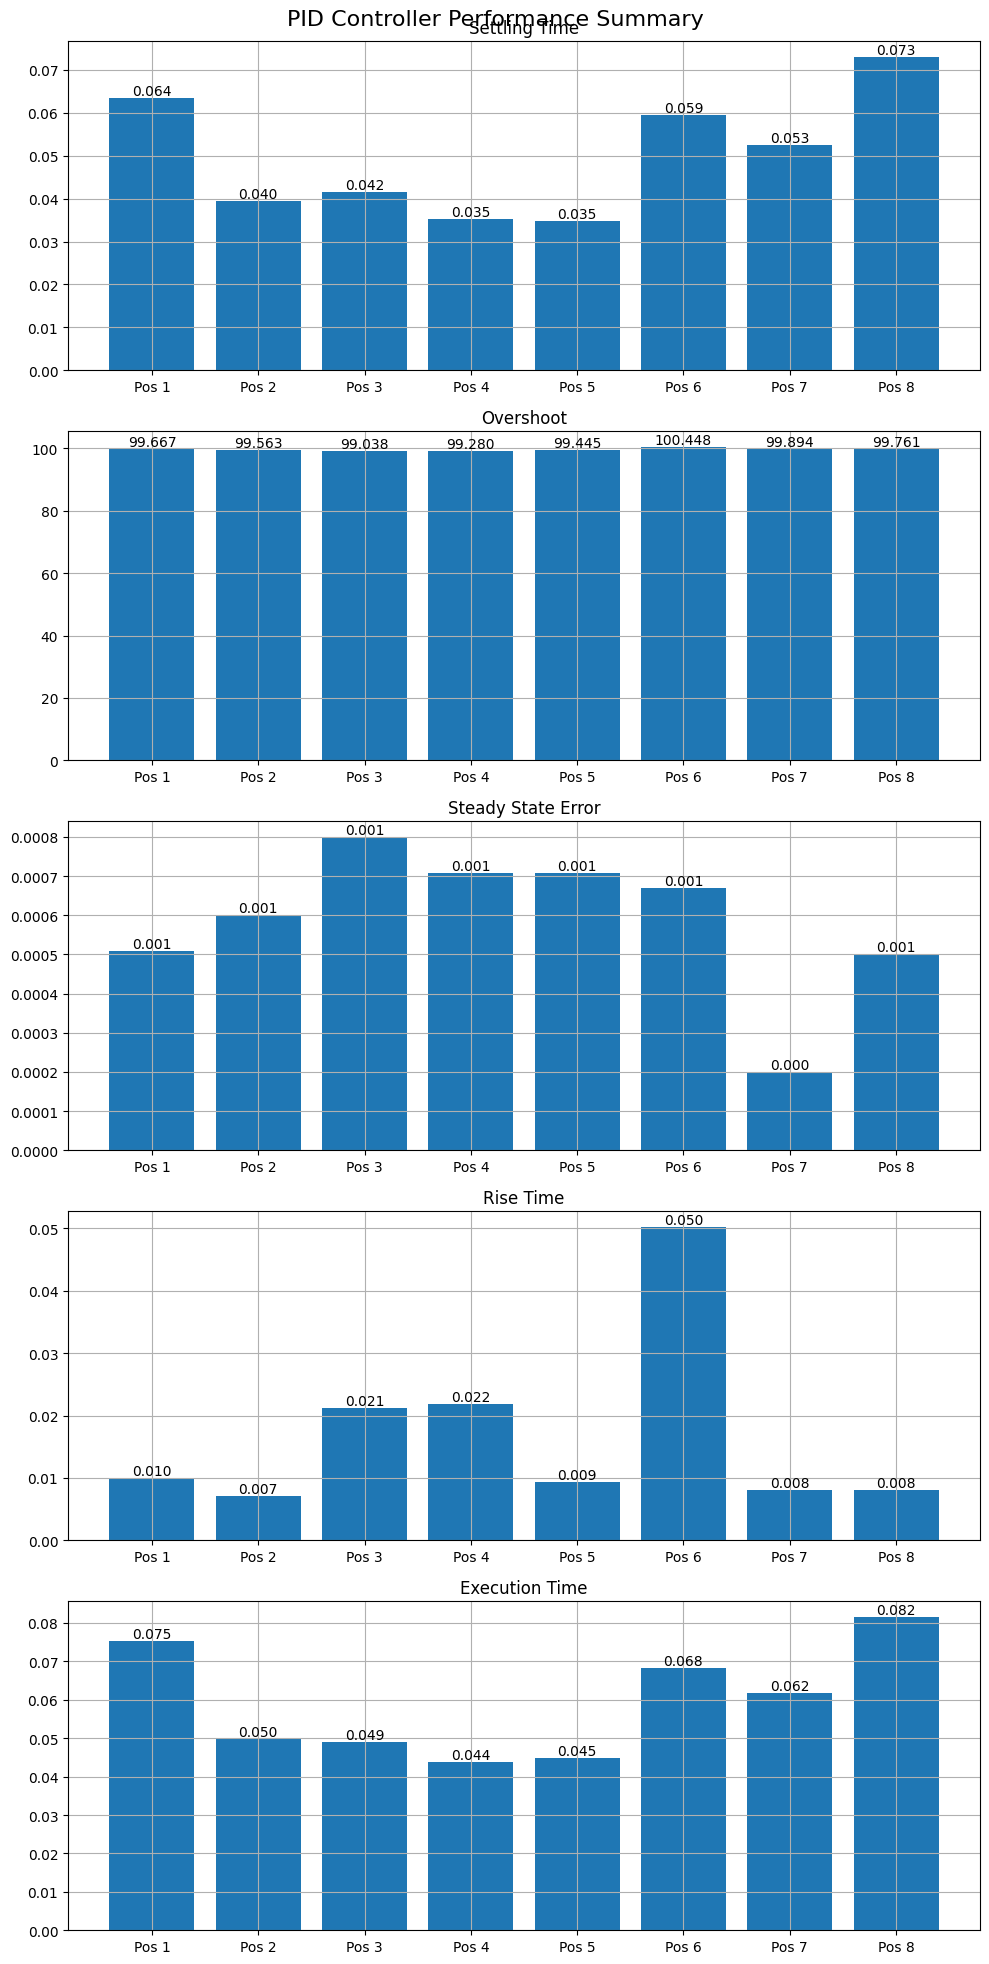


PID Controller Performance Summary:
Average Settling Time: 0.050s
Average Overshoot: 99.6%
Average Steady-State Error: 0.6mm
Average Rise Time: 0.017s
Average Execution Time: 0.059s


In [2]:
def main():
    """Main function to run PID controller benchmarking"""
    try:
        benchmark = ControllerBenchmark()
        results = benchmark.benchmark_pid()
        
        # Save results
        with open('pid_benchmark_results.json', 'w') as f:
            json.dump(results, f, indent=4, cls=NumpyEncoder)
        
        # Create summary plots
        benchmark.plot_summary(results)
        
        # Print summary
        print("\nPID Controller Performance Summary:")
        metrics = results['average_metrics']
        print(f"Average Settling Time: {metrics['settling_time']:.3f}s")
        print(f"Average Overshoot: {metrics['overshoot']:.1f}%")
        print(f"Average Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm")
        print(f"Average Rise Time: {metrics['rise_time']:.3f}s")
        print(f"Average Execution Time: {metrics['execution_time']:.3f}s")
            
    except Exception as e:
        print(f"Error in benchmarking: {str(e)}")

if __name__ == "__main__":
    main()

In [26]:
import sys
sys.path.append("./../task11")
sys.path.append("./../task12")

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import json
import time
from test_pid_controller import PIDTester
from train_ot2_rl import setup_eval_environment
from stable_baselines3 import SAC

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                          np.int16, np.int32, np.int64, np.uint8,
                          np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

class RLControllerBenchmark:
    def __init__(self):
        """Initialize benchmark environment and RL controller"""
        # Define workspace bounds (adjusted based on actual robot limits)
        self.x_bounds = (-0.1871, 0.253)
        self.y_bounds = (-0.1705, 0.2195)
        self.z_bounds = (0.0, 0.15)  # Added Z bounds
        
        # Setup environment and load model
        self.env = setup_eval_environment(render=False)
        
        # Load normalization stats if available
        if os.path.exists("./../task11/best_model/vec_normalize.pkl"):
            self.env = VecNormalize.load(
                "./../task11/best_model/vec_normalize.pkl",
                self.env
            )
            print("Loaded normalization stats")
        
        # Set training mode to False for evaluation
        self.env.training = False
        self.env.norm_reward = False
        
        self.model = self.load_rl_model()
        
        # Define test positions (adjusted to be well within bounds)
        self.test_positions = [
            np.array([-0.08, 0.08, 0.119]),    # Left
            np.array([-0.05, 0.15, 0.119]),    # Top-left
            np.array([0.07, 0.17, 0.119]),     # Top
            np.array([0.15, 0.15, 0.119]),     # Top-right
            np.array([0.20, 0.08, 0.119]),     # Right
            np.array([0.15, -0.08, 0.119]),    # Bottom-right
            np.array([0.07, -0.10, 0.119]),    # Bottom
            np.array([-0.05, -0.08, 0.119])    # Bottom-left
        ]

        # Set environment parameters
        self.env.training = False
        self.env.norm_reward = False
        self.env.reset()  # Initial reset to ensure environment is ready
        
        # Add small delay to ensure environment is stable
        time.sleep(0.1)

    def is_valid_position(self, pos: np.ndarray) -> bool:
        """Check if position is valid (within bounds and finite)"""
        try:
            if not np.isfinite(pos).all():
                return False
            if not (self.x_bounds[0] <= pos[0] <= self.x_bounds[1]):
                return False
            if not (self.y_bounds[0] <= pos[1] <= self.y_bounds[1]):
                return False
            if not (self.z_bounds[0] <= pos[2] <= self.z_bounds[1]):
                return False
            return True
        except:
            return False

    def benchmark_rl(self) -> Dict[str, Any]:
        """Benchmark RL controller"""
        all_metrics = []
        trajectory_data = []
        max_steps = 1000  # Maximum steps per test
        max_retries = 5   # Maximum retries per position
        
        for i, target_pos in enumerate(self.test_positions):
            print(f"\nTesting RL controller - Position {i+1}/{len(self.test_positions)}")
            print(f"Target position: {target_pos}")
            
            retries = 0
            success = False
            
            while retries < max_retries and not success:
                try:
                    # Reset environment with target position
                    self.env.goal_position = target_pos
                    obs = self.env.reset()[0]  # Get first element of tuple
                    
                    # Ensure obs is 1D and extract initial position
                    obs = obs.reshape(-1)  # Reshape to 1D array
                    initial_pos = obs[:3]  # First 3 elements are position
                    
                    if not self.is_valid_position(initial_pos):
                        print(f"Invalid initial position: {initial_pos}, retrying...")
                        retries += 1
                        continue
                    
                    print(f"Initial position: {initial_pos}")
                    
                    # Initialize metrics collection
                    distances = []
                    times = []
                    velocities = []
                    positions = []
                    start_time = time.time()
                    step_count = 0
                    
                    while step_count < max_steps:
                        # Get action from RL model
                        action, _ = self.model.predict(obs.reshape(1,-1), deterministic=True)  # Reshape for model input
                        
                        # Take step in environment
                        step_result = self.env.step(action)
                        if len(step_result) == 5:
                            obs, reward, terminated, truncated, info = step_result
                        else:
                            obs, reward, terminated, info = step_result
                            truncated = False
                        
                        # Ensure obs is 1D
                        obs = obs.reshape(-1)
                        
                        # Get current position from observation
                        current_pos = obs[:3]  # First 3 elements are position
                        current_time = time.time() - start_time
                        
                        # Calculate distance to target
                        distance = np.linalg.norm(target_pos - current_pos)
                        
                        # Extract velocity (elements 3-5)
                        velocity = np.linalg.norm(obs[3:6])
                        
                        distances.append(float(distance))
                        times.append(float(current_time))
                        velocities.append(float(velocity))
                        positions.append(current_pos.tolist())
                        
                        step_count += 1
                        
                        # Print debugging info
                        if step_count % 100 == 0:
                            print(f"Step {step_count}: Distance = {distance:.3f}m")
                        
                        # Check termination conditions
                        if distance < 0.001 or terminated or truncated:
                            break
                                                            
                    final_pos = current_pos
                    
                    if not self.is_valid_position(final_pos):
                        print(f"Invalid final position: {final_pos}, retrying...")
                        retries += 1
                        continue
                        
                    print(f"Final position: {final_pos}")
                    print(f"Final distance: {distances[-1]*1000:.2f}mm")
                    
                    # Calculate metrics
                    metrics = self.calculate_performance_metrics(
                        distances, times, distances[0]
                    )
                    
                    # Add execution time metric
                    metrics['execution_time'] = float(time.time() - start_time)
                    
                    # Store data
                    trajectory_data.append({
                        'initial_pos': initial_pos.tolist(),
                        'target_pos': target_pos.tolist(),
                        'final_pos': final_pos.tolist(),
                        'distances': distances,
                        'times': times,
                        'velocities': velocities,
                        'positions': positions
                    })
                    
                    all_metrics.append(metrics)
                    success = True
                    
                except Exception as e:
                    print(f"Error during test {i+1}: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    retries += 1
            
            if not success:
                print(f"Failed to complete test for position {i+1} after {max_retries} retries")
        
        if not all_metrics:
            raise ValueError("No successful tests completed")
            
        # Calculate average metrics
        avg_metrics = {
            key: float(np.mean([m[key] for m in all_metrics]))
            for key in all_metrics[0].keys()
        }
        
        return {
            'average_metrics': avg_metrics,
            'all_metrics': all_metrics,
            'trajectory_data': trajectory_data
        }

    def extract_position(self, obs) -> np.ndarray:
        """Extract position from observation safely"""
        if isinstance(obs, np.ndarray):
            return obs[:3]
        elif isinstance(obs, dict):
            # Add handling for dict format if needed
            raise ValueError("Dict observation format not implemented")
        else:
            try:
                return np.array(obs[:3]).reshape(-1)
            except:
                raise ValueError(f"Unable to extract position from observation type: {type(obs)}")

    def load_rl_model(self):
        """Load the trained RL model"""
        hyperparams = {
            "learning_rate": 1e-4,
            "buffer_size": 100000,
            "batch_size": 256,
            "tau": 0.005,
            "gamma": 0.995,
            "train_freq": (1, "step"),
            "gradient_steps": 1,
            "ent_coef": "auto_1.0",
        }
        
        return SAC.load(
            "./../../task11/ot2_twin/best_model/best_model",
            env=self.env,
            device='cpu',
            custom_objects=hyperparams
        )

    def calculate_performance_metrics(self, distances: List[float], times: List[float], initial_distance: float) -> Dict[str, float]:
        """Calculate performance metrics for a single test"""
        distances = np.array(distances)
        times = np.array(times)
        
        # Calculate settling time (time to reach and stay within 2% of initial distance)
        settling_threshold = 0.02 * initial_distance
        settled_indices = np.where(distances <= settling_threshold)[0]
        settling_time = times[settled_indices[0]] if len(settled_indices) > 0 else times[-1]
        
        # Calculate overshoot
        overshoot = (np.max(distances) - distances[-1]) / initial_distance * 100
        
        # Calculate steady-state error
        steady_state_error = distances[-1]
        
        # Calculate rise time (time to go from 10% to 90% of total distance)
        rise_start = np.where(distances <= 0.9 * initial_distance)[0][0]
        rise_end = np.where(distances <= 0.1 * initial_distance)[0][0]
        rise_time = times[rise_end] - times[rise_start]
        
        return {
            'settling_time': settling_time,
            'overshoot': overshoot,
            'steady_state_error': steady_state_error,
            'rise_time': rise_time
        }

    def plot_test_results(self, distances: List[float], times: List[float], 
                         velocities: List[float], metrics: Dict[str, float]):
        """Plot results for a single test"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot distance vs time
        ax1.plot(times, distances, 'b-', label='Distance to Target')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Distance (m)')
        ax1.set_title('Distance to Target vs Time')
        ax1.grid(True)
        
        # Add metrics to plot
        metrics_text = (
            f"Settling Time: {metrics['settling_time']:.3f}s\n"
            f"Overshoot: {metrics['overshoot']:.1f}%\n"
            f"Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm\n"
            f"Rise Time: {metrics['rise_time']:.3f}s\n"
            f"Execution Time: {metrics['execution_time']:.3f}s"
        )
        ax1.text(0.02, 0.98, metrics_text,
                transform=ax1.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Plot velocity vs time
        ax2.plot(times, velocities, 'r-', label='Velocity')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Velocity (m/s)')
        ax2.set_title('Velocity vs Time')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_summary(self, results: Dict):
        """Create summary plots for RL controller performance"""
        metrics = ['settling_time', 'overshoot', 'steady_state_error', 'rise_time', 'execution_time']
        
        fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 4*len(metrics)))
        fig.suptitle('RL Controller Performance Summary', fontsize=16)
        
        all_metrics = results['all_metrics']
        positions = [f"Pos {i+1}" for i in range(len(all_metrics))]
        
        for i, metric in enumerate(metrics):
            values = [m[metric] for m in all_metrics]
            
            axes[i].bar(positions, values)
            axes[i].set_title(f'{metric.replace("_", " ").title()}')
            axes[i].grid(True)
            
            # Add value labels on bars
            for j, v in enumerate(values):
                axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig('rl_performance_summary.png')
        plt.show()

    def reset_environment(self, target_pos):
        """Reset environment and ensure it's in a valid state"""
        self.env.goal_position = target_pos
        obs = self.env.reset()[0]
        
        # Wait a short time for physics to settle
        time.sleep(0.1)
        
        return obs

def main():
    """Main function to run RL controller benchmarking"""
    try:
        benchmark = RLControllerBenchmark()
        results = benchmark.benchmark_rl()
        
        # Save results
        with open('rl_benchmark_results.json', 'w') as f:
            json.dump(results, f, indent=4, cls=NumpyEncoder)
        
        # Create summary plots
        benchmark.plot_summary(results)
        
        # Print summary
        print("\nRL Controller Performance Summary:")
        metrics = results['average_metrics']
        print(f"Average Settling Time: {metrics['settling_time']:.3f}s")
        print(f"Average Overshoot: {metrics['overshoot']:.1f}%")
        print(f"Average Steady-State Error: {metrics['steady_state_error']*1000:.1f}mm")
        print(f"Average Rise Time: {metrics['rise_time']:.3f}s")
        print(f"Average Execution Time: {metrics['execution_time']:.3f}s")
            
    except Exception as e:
        print(f"Error in benchmarking: {str(e)}")

if __name__ == "__main__":
    main()


Testing RL controller - Position 1/8
Target position: [-0.08   0.08   0.119]
Initial position: [-0.08496952 -0.04131395  0.12180063]
Step 100: Distance = 0.517m
Step 200: Distance = 0.527m
Step 300: Distance = 0.530m
Step 400: Distance = 0.514m
Step 500: Distance = 0.521m
Step 600: Distance = 0.499m
Step 700: Distance = 0.506m
Step 800: Distance = 0.494m
Step 900: Distance = 0.484m
Step 1000: Distance = 0.435m
Invalid final position: [ 0.29525083 -0.13738409  0.15865701], retrying...
Invalid initial position: [-0.2791242   0.0529741   0.09807444], retrying...
Invalid initial position: [-0.18141669  0.25200388 -0.08102898], retrying...
Initial position: [ 0.04794466 -0.16282344  0.0319781 ]
Step 100: Distance = 0.257m
Step 200: Distance = 0.255m
Step 300: Distance = 0.265m
Step 400: Distance = 0.271m
Step 500: Distance = 0.309m
Step 600: Distance = 0.334m
Step 700: Distance = 0.363m
Step 800: Distance = 0.369m
Step 900: Distance = 0.399m
Step 1000: Distance = 0.377m
Invalid final posit

Traceback (most recent call last):
  File "C:\Users\Soheil\AppData\Local\Temp\ipykernel_45184\3986740551.py", line 178, in benchmark_rl
    metrics = self.calculate_performance_metrics(
  File "C:\Users\Soheil\AppData\Local\Temp\ipykernel_45184\3986740551.py", line 274, in calculate_performance_metrics
    rise_end = np.where(distances <= 0.1 * initial_distance)[0][0]
IndexError: index 0 is out of bounds for axis 0 with size 0


Step 100: Distance = 0.243m
Step 200: Distance = 0.254m
Step 300: Distance = 0.221m
Step 400: Distance = 0.231m
Step 500: Distance = 0.236m
Step 600: Distance = 0.232m
Step 700: Distance = 0.194m
Step 800: Distance = 0.200m
Step 900: Distance = 0.200m
Step 1000: Distance = 0.211m
Invalid final position: [-0.1547714   0.32997808  0.15340808], retrying...
Failed to complete test for position 2 after 5 retries

Testing RL controller - Position 3/8
Target position: [0.07  0.17  0.119]
Invalid initial position: [ 0.32135436 -0.00072649 -0.08664982], retrying...
Invalid initial position: [ 0.12442529  0.12879875 -0.03617764], retrying...
Invalid initial position: [ 0.0700205  -0.3536179  -0.03766574], retrying...
Invalid initial position: [-0.3131032   0.03846799 -0.03117265], retrying...
Invalid initial position: [-0.16338229  0.09920716 -0.07854527], retrying...
Failed to complete test for position 3 after 5 retries

Testing RL controller - Position 4/8
Target position: [0.15  0.15  0.119]

Traceback (most recent call last):
  File "C:\Users\Soheil\AppData\Local\Temp\ipykernel_45184\3986740551.py", line 178, in benchmark_rl
    metrics = self.calculate_performance_metrics(
  File "C:\Users\Soheil\AppData\Local\Temp\ipykernel_45184\3986740551.py", line 274, in calculate_performance_metrics
    rise_end = np.where(distances <= 0.1 * initial_distance)[0][0]
IndexError: index 0 is out of bounds for axis 0 with size 0


Step 100: Distance = 0.114m
Step 200: Distance = 0.091m
Step 300: Distance = 0.063m
Step 400: Distance = 0.034m
Step 500: Distance = 0.083m
Step 600: Distance = 0.120m
Step 700: Distance = 0.157m
Step 800: Distance = 0.197m
Step 900: Distance = 0.218m
Step 1000: Distance = 0.209m
Invalid final position: [0.3734433  0.04560169 0.23071752], retrying...
Failed to complete test for position 5 after 5 retries

Testing RL controller - Position 6/8
Target position: [ 0.15  -0.08   0.119]
Invalid initial position: [-0.02817124  0.10773222 -0.07735959], retrying...
Invalid initial position: [-0.37900507 -0.29041785 -0.06967507], retrying...
Invalid initial position: [-0.09867701  0.18507722 -0.0429779 ], retrying...
Invalid initial position: [-0.03741328  0.12022645 -0.0680573 ], retrying...
Invalid initial position: [-0.08926675 -0.3089002  -0.02694267], retrying...
Failed to complete test for position 6 after 5 retries

Testing RL controller - Position 7/8
Target position: [ 0.07  -0.1    0.1